In [33]:
import json
from pathlib import Path

import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path

NB_DIR = Path().resolve()

ROOT = NB_DIR.parent
DATA_PATH = Path(ROOT, "data/lane_segmentation_yolo/new")  # folder that contains images + .json files

In [34]:

print("DATA_PATH exists:", DATA_PATH.exists())
print("PNG files:", len(list(DATA_PATH.glob("*.png"))))
print("JSON files:", len(list(DATA_PATH.glob("*.json"))))

# Inspect ONE json directly
j = list(DATA_PATH.glob("*.json"))[0]
print("\nExample JSON path:", j)

with open(j) as f:
    data = json.load(f)

print("imagePath in JSON:", data["imagePath"])
print("Number of shapes:", len(data["shapes"]))
print("Shape labels:", [s["label"] for s in data["shapes"]])
print("Shape types:", [s["shape_type"] for s in data["shapes"]])


DATA_PATH exists: True
PNG files: 97
JSON files: 97

Example JSON path: C:\Users\jleto\Projects\rev-vision\data\lane_segmentation_yolo\new\frame_0000.json
imagePath in JSON: frame_0000.png
Number of shapes: 1
Shape labels: ['lane']
Shape types: ['polygon']


In [35]:
from pathlib import Path
import json
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class EgoLaneDataset(Dataset):
    def __init__(self, root, fixed_size=(360, 640)):
        """
        root: Path to folder containing PNGs and JSONs
        fixed_size: (height, width) for resizing all images
        """
        self.root = Path(root)
        self.fixed_size = fixed_size  # H, W
        self.jsons = sorted(self.root.glob("*.json"))

    def __len__(self):
        return len(self.jsons)

    def __getitem__(self, idx):
        jpath = self.jsons[idx]
        with open(jpath) as f:
            data = json.load(f)

        img_path = self.root / data["imagePath"]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        H0, W0 = img.shape[:2]
        H1, W1 = self.fixed_size

        # resize image to fixed size
        img = cv2.resize(img, (W1, H1))

        # build binary mask for lane polygon(s)
        mask = np.zeros((H1, W1), dtype=np.uint8)

        for shape in data["shapes"]:
            if shape["label"] == "lane":  # <-- use your LabelMe label
                pts = np.array(shape["points"], dtype=np.float32)

                # scale polygon coordinates to resized image
                pts[:, 0] *= W1 / W0
                pts[:, 1] *= H1 / H0

                pts = pts.astype(np.int32)
                cv2.fillPoly(mask, [pts], 1)

        # convert image to CHW and float
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # CHW

        # add channel dimension to mask
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return torch.from_numpy(img), mask


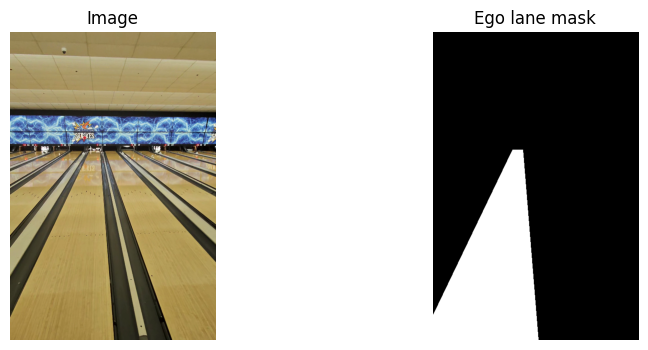

In [39]:
ds = EgoLaneDataset(DATA_PATH, fixed_size=(720, 480))  # height, width

import  random
i = random.randrange(len(ds))
img, mask = ds[i]

img_np = img.permute(1, 2, 0).numpy()
mask_np = mask[0].numpy()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Ego lane mask")
plt.imshow(mask_np, cmap="gray")
plt.axis("off")

plt.show()


In [41]:
from torch.utils.data import DataLoader

BATCH_SIZE = 4

ds = EgoLaneDataset(DATA_PATH, fixed_size=(720, 480))  # height, width
loader = DataLoader(ds, batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=0)


In [42]:
import torch.nn as nn
import torchvision.models as models

class LaneSegmentationModel(nn.Module):
    def __init__(self, n_classes=1, backbone='resnet18', pretrained=True):
        super().__init__()
        if backbone == 'resnet18':
            self.encoder = models.resnet18(pretrained=pretrained)
            self.encoder_layers = list(self.encoder.children())
            
            # Remove fully connected layer and avgpool
            self.encoder = nn.Sequential(*self.encoder_layers[:-2])
            encoder_channels = 512
        else:
            raise NotImplementedError("Only resnet18 backbone implemented for now")
        
        # Simple decoder: upsample + conv
        self.decoder = nn.Sequential(
            nn.Conv2d(encoder_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, n_classes, kernel_size=1)
        )
    
    def forward(self, x):
        features = self.encoder(x)
        out = self.decoder(features)
        return out


In [43]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LaneSegmentationModel(n_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()  # single-channel mask
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# --- dataset ---
ds = EgoLaneDataset(DATA_PATH, fixed_size=(720, 480))  # height, width
loader = DataLoader(ds, batch_size=2, shuffle=True, num_workers=0)

# --- model ---
model = LaneSegmentationModel(n_classes=1).to(device)

# --- loss and optimizer ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50

# --- training loop ---
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(imgs)

        # --- interpolate output to match mask size ---
        outputs = nn.functional.interpolate(
            outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False
        )

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(ds)
    print(f"Epoch {epoch}/{EPOCHS} | Loss: {epoch_loss:.6f}")


Epoch 1/50 | Loss: 0.271411
Epoch 2/50 | Loss: 0.151522
Epoch 3/50 | Loss: 0.073858
Epoch 4/50 | Loss: 0.068360
Epoch 5/50 | Loss: 0.081006
Epoch 6/50 | Loss: 0.046983
Epoch 7/50 | Loss: 0.043342
Epoch 8/50 | Loss: 0.023096
Epoch 9/50 | Loss: 0.039480
Epoch 10/50 | Loss: 0.032800
Epoch 11/50 | Loss: 0.019786
Epoch 12/50 | Loss: 0.022166
Epoch 13/50 | Loss: 0.020214
Epoch 14/50 | Loss: 0.019470
Epoch 15/50 | Loss: 0.023572
Epoch 16/50 | Loss: 0.011006
Epoch 17/50 | Loss: 0.013487
Epoch 18/50 | Loss: 0.014205
Epoch 19/50 | Loss: 0.008866
Epoch 20/50 | Loss: 0.008122
Epoch 21/50 | Loss: 0.007357
Epoch 22/50 | Loss: 0.008835
Epoch 23/50 | Loss: 0.014693
Epoch 24/50 | Loss: 0.019710
Epoch 25/50 | Loss: 0.061433
Epoch 26/50 | Loss: 0.046603
Epoch 27/50 | Loss: 0.035452
Epoch 28/50 | Loss: 0.013338
Epoch 29/50 | Loss: 0.013122
Epoch 30/50 | Loss: 0.016915
Epoch 31/50 | Loss: 0.014719
Epoch 32/50 | Loss: 0.014097
Epoch 33/50 | Loss: 0.018558
Epoch 34/50 | Loss: 0.013952
Epoch 35/50 | Loss: 0.0

In [47]:
# --- save the trained model ---
torch.save(model.state_dict(), "lane_segmentation_model.pt")
print("Model saved to lane_segmentation_model.pt")


Model saved to lane_segmentation_model.pt


In [2]:
import random
import matplotlib.pyplot as plt
import torch
import numpy as np

# --- load model ---
model = LaneSegmentationModel(n_classes=1).to(device)
model.load_state_dict(torch.load("lane_segmentation_model.pt", map_location=device))
model.eval()

# --- pick random image ---
i = random.randrange(len(ds))
img, mask_gt = ds[i]  # mask_gt optional, for comparison

img_tensor = img.unsqueeze(0).to(device)

with torch.no_grad():
    pred_logits = model(img_tensor)
    pred_logits = torch.nn.functional.interpolate(
        pred_logits, size=mask_gt.shape[-2:], mode='bilinear', align_corners=False
    )
    pred_mask = torch.sigmoid(pred_logits)[0,0].cpu().numpy()  # 0-1 probabilities

# --- convert image back to HWC for plotting ---
img_np = img.permute(1,2,0).numpy()

# --- plot ---
plt.figure(figsize=(10,5))
plt.imshow(img_np)
plt.imshow(pred_mask, cmap='Reds', alpha=0.4)
plt.axis("off")
plt.title("Input Image with Predicted Lane Mask Overlay")
plt.show()


NameError: name 'LaneSegmentationModel' is not defined